In [424]:
import requests
import json
import matplotlib.pyplot as plt
import matplotlib
import time
import pandas as pd
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter
from matplotlib.dates import HourLocator
from bs4 import BeautifulSoup

In [210]:
def toSecond(timeString):
    if timeString=="-":
        return 0
    return int(timeString[0:2])*60*60+int(timeString[3:5])*60+int(timeString[6:8])

In [322]:
fig_size = plt.rcParams["figure.figsize"]
print("current_size : " + str(fig_size))
fig_size[0] = 20
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

current_size : [12.0, 9.0]


In [226]:
def getUserProfile(bib):
    userData = {}
    userData['bib'] = bib 
    pid = "10510"

    text = requests.get("http://liverun.co.kr/desktop/userSelectBib.php?rtype=2&pid="+pid+"&bib="+str(bib)).text
    soup = BeautifulSoup(text, 'html.parser')
    if "사용자가 없습니다." in text:
        raise Exception("use not found")
    
    table = soup.find('table').find_all('td')
    userData['name'] = table[1].find('a').text
    userData['detailUrl'] = "http://liverun.co.kr/desktop"+table[1].find('a').attrs['href'][1:]
    userData['gender'] = table[2].text.strip()
    userData['track'] = table[3].text.strip()
    
    text = requests.get(userData['detailUrl']).text
    soup = BeautifulSoup(text, 'html.parser')
    
    records = soup.find('table').find_all('tr')[6].find_all('img')
    recordResult = ""
    for record in records:
        recordTime = record.attrs['src'][13]
        if recordTime=="s":
            recordTime=":"
        recordResult+=recordTime
        
    userData['record']=recordResult
    userData['record_second']=toSecond(recordResult)
    userData['is_complete']=True
    
    userData['time'] = []
    timesTable = soup.find('table').find_all('tr')[10].find_all('tr')[2:]
    for times in timesTable:
        timeData = times.find_all('td')
        timeString = timeData[1].text.strip()
        if timeString=="-":
            userData['is_complete']=False
            
        userData['time'].append(
        {
            'name':timeData[0].text,
            'time':timeString,
            'second':toSecond(timeString)
        })
        
    return userData

In [233]:
userData = []
for i in range(1000, 2699):
    try:
        user = getUserProfile(str(i))
    except:
        print("not found : " + str(i))
        continue
    userData.append(user)
    if i%100==0:
        print(str(i)+ " done")

not found : 1000
1100 done
1200 done
1300 done
1400 done
1500 done
1600 done
1700 done
1800 done
1900 done
2000 done
2100 done
2200 done
2300 done
2400 done
2500 done
2600 done
not found : 2691
not found : 2692
not found : 2693
not found : 2694
not found : 2695
not found : 2696
not found : 2697
not found : 2698


In [235]:
with open('data.txt', 'w') as file:
     file.write(json.dumps(userData))

In [238]:
with open('data.txt') as f:
    userData = json.load(f)

In [262]:
def needSkip(user):
    if user['name'] == "예비" or user['record_second'] == 0 or user['is_complete'] == False:
        return True
    else:
        return False

In [295]:
all_count = 0
record_count = 0
complete_count = 0

max_record_second = 0
min_record_second = 9999999999
for user in userData:
    if user['name'] != "예비":
        all_count=all_count+1
    else:
        continue
    if user['record_second']!=0:
        record_count=record_count+1
    else:
        continue
    if user['is_complete']:
        complete_count=complete_count+1
    else:
        continue
        
    if max_record_second < user['record_second']:
        max_record_second = user['record_second']
        max_record_user = user
    if min_record_second > user['record_second']:
        min_record_second = user['record_second']
        min_record_user = user

time_rank=[0,0,0,0,0]
for user in userData:
    if needSkip(user):
        continue
    for j in range(0,5):
        if user['time'][j]['second'] <= min_record_user['time'][j]['second']:
            time_rank[j]=time_rank[j]+1
    
print("55k 총 참여자 : " + str(all_count))
print("실제 대회 참여자(기록 존재) : " + str(record_count))
print("기록 누락 없는 참여자(모든 측정구간 통과) : " + str(complete_count))
print()
print("최단기록 : " + min_record_user['record'])
print("최장기록 : " + max_record_user['record'])
print()
print("==최단기록 참가자 기록==")
print("5km 런닝          : " + min_record_user['time'][0]['time'] + "(" + str(time_rank[0]) + "위)")
print("런닝->사이클 교환시간 : " + min_record_user['time'][1]['time'] + "(" + str(time_rank[1]) + "위)")
print("40.5km 사이클      : " + min_record_user['time'][2]['time'] + "(" + str(time_rank[2]) + "위)")
print("사이클->런닝 교환시간 : " + min_record_user['time'][3]['time'] + "(" + str(time_rank[3]) + "위)")
print("10km 런닝         : " + min_record_user['time'][4]['time'] + "(" + str(time_rank[4]) + "위)")

55k 총 참여자 : 1673
실제 대회 참여자(기록 존재) : 1307
기록 누락 없는 참여자(모든 측정구간 통과) : 1233

최단기록 : 02:08:44
최장기록 : 04:01:39

==최단기록 참가자 기록==
5km 런닝          : 00:18:33(9위)
런닝->사이클 교환시간 : 00:01:33(15위)
40.5km 사이클      : 01:03:01(1위)
사이클->런닝 교환시간 : 00:01:29(5위)
10km 런닝         : 00:44:10(6위)


In [403]:
for user1 in userData:
    if needSkip(user1):
        continue
    user1['rank'] = 1
    for user2 in userData:
        if needSkip(user2):
            continue
        if user1['record_second'] > user2['record_second']:
            user1['rank']=user1['rank']+1
        elif user1['record_second'] == user2['record_second'] and user1['name'] < user2['name']:
            user1['rank']=user1['rank']+1

In [292]:
my_bib="2341"
my_data=None
for user in userData:
    if user['bib']==my_bib:
        my_data=user
        break

if my_data==None:
    raise Exception("user not found")

rank=0
time_rank=[0,0,0,0,0]
for user in userData:
    if needSkip(user):
        continue
    if user['record_second'] <= my_data['record_second']:
        rank=rank+1
    for j in range(0,5):
        if user['time'][j]['second'] <= my_data['time'][j]['second']:
            time_rank[j]=time_rank[j]+1

print("내 이름 : " + my_data['name'])
print("내 기록 : " + my_data['record'])
print("내 등수 : " + str(rank) + "/" + str(complete_count)+"등 (상위 " + str(rank/complete_count*100)+"%)")
print()
print("5km 런닝          : " + my_data['time'][0]['time'] + "(" + str(time_rank[0]) + "위)")
print("런닝->사이클 교환시간 : " + my_data['time'][1]['time'] + "(" + str(time_rank[1]) + "위)")
print("40.5km 사이클      : " + my_data['time'][2]['time'] + "(" + str(time_rank[2]) + "위)")
print("사이클->런닝 교환시간 : " + my_data['time'][3]['time'] + "(" + str(time_rank[3]) + "위)")
print("10km 런닝         : " + my_data['time'][4]['time'] + "(" + str(time_rank[4]) + "위)")

내 이름 : 정성민
내 기록 : 02:45:50
내 등수 : 208/1233등 (상위 16.86942416869424%)

5km 런닝          : 00:23:26(258위)
런닝->사이클 교환시간 : 00:05:18(1090위)
40.5km 사이클      : 01:16:09(352위)
사이클->런닝 교환시간 : 00:05:50(1157위)
10km 런닝         : 00:55:08(117위)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


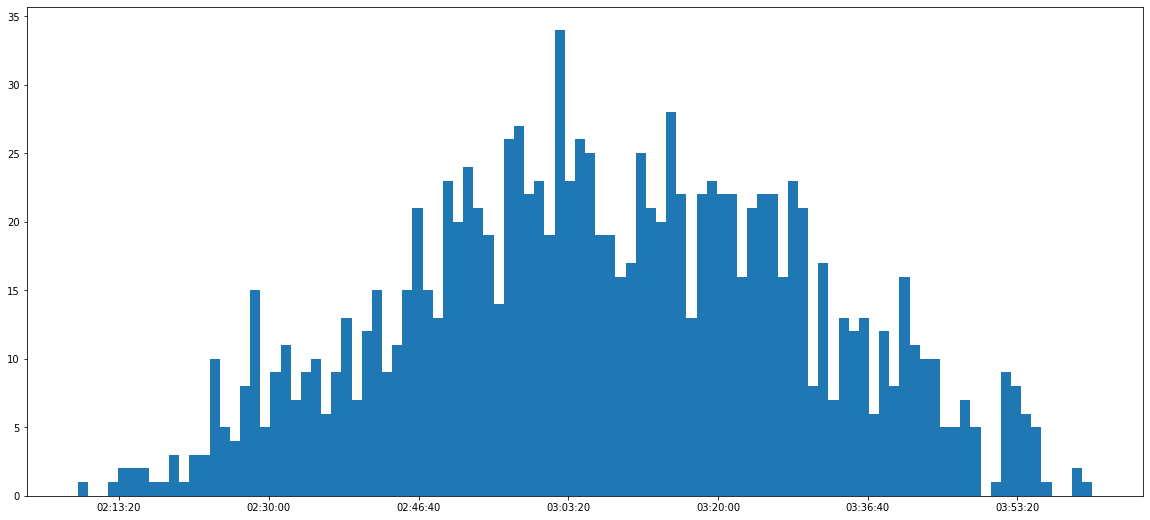

<Figure size 1440x648 with 0 Axes>

In [412]:
record_list = []
for user in userData:
    if needSkip(user):
        continue
    record_list.append(user['record_second'])
    
plt.hist(record_list, bins=100)
ax = plt.subplot()

def time_format(x, pos=None):
    return time.strftime("%H:%M:%S", time.gmtime(x))

ax.xaxis.set_major_formatter(ticker.FuncFormatter(time_format))

plt.show()
plt.clf()

In [404]:
def getUserByRank(rank):
    for user in userData:
        if user['rank'] == rank:
            return user
    raise Exception("not found")
def searchRange(start, end):
    dataList=[]
    for i in range(start, end):
        user = getUserByRank(i)
#         dataList.append({
#             "bib":user['bib'], 
#             "name":user['name'],
#             "record":user['record'],
#             "Run1":user['time'][0]['time'],
#             "Change1":user['time'][1]['time'],
#             "Cycle":user['time'][2]['time'],
#             "Change2":user['time'][3]['time'],
#             "Run2":user['time'][4]['time'],
#         })
        dataList.append([
            user['rank'],
            user['bib'], 
            user['name'],
            user['record'],
            user['time'][0]['time'],
            user['time'][1]['time'],
            user['time'][2]['time'],
            user['time'][3]['time'],
            user['time'][4]['time'],
        ])
    return pd.DataFrame(dataList, columns=["rank", "bib", "name", "record", "Run1", "Change1", "Cycle", "Change2", "Run2"])

In [408]:
# getUserByRank(105)
searchRange(150,220)

,rank,bib,name,record,Run1,Change1,Cycle,Change2,Run2
0,150,1175,김기원,02:40:31,00:22:53,00:02:30,01:16:55,00:02:43,00:55:32
1,151,1482,노현우,02:40:44,00:21:15,00:03:48,01:12:06,00:04:42,00:58:54
2,152,1503,문성은,02:40:56,00:23:36,00:02:24,01:14:45,00:02:51,00:57:22
3,153,2162,이주형,02:41:06,00:23:49,00:01:52,01:11:21,00:02:23,01:01:42
4,154,2182,이창해,02:41:13,00:20:23,00:02:11,01:27:08,00:02:15,00:49:18
5,155,2167,이준직,02:41:13,00:23:30,00:02:08,01:11:57,00:04:11,00:59:28
6,156,2556,한대진,02:41:17,00:24:42,00:03:34,01:15:52,00:03:49,00:53:22
7,157,2276,장준혁,02:41:21,00:22:00,00:02:50,01:11:46,00:03:22,01:01:25
8,158,1204,김동우,02:41:22,00:28:03,00:02:53,01:08:11,00:03:41,00:58:35
9,159,2631,황원제,02:41:24,00:22:40,00:01:43,01:16:54,00:01:40,00:58:28


In [427]:
def formatter(x):
    return time.strftime("%H:%M:%S", time.gmtime(x))

for i in range(0, 22):
    record = {'Run1':0, 'Change1':0, 'Cycle':0, 'Change2':0, 'Run2':0}
    for j in range(i*10+1, (i+1)*10+1):
        user = getUserByRank(j)
        record['Run1']+=user['time'][0]['second']
        record['Change1']+=user['time'][1]['second']
        record['Cycle']+=user['time'][2]['second']
        record['Change2']+=user['time'][3]['second']
        record['Run2']+=user['time'][4]['second']
    print(str(i*10+1)+"~"+str((i+1)*10+1)+"등")
    print("Run1 : " + formatter(record['Run1']/10) + " Change1 : " + formatter(record['Change1']/10) + " Cycle : " + formatter(record['Cycle']/10) + " Change2 : " + formatter(record['Change2']/10) + " Run2 : " + formatter(record['Run2']/10))
    print()

1~11등
Run1 : 00:19:12 Change1 : 00:02:04 Cycle : 01:06:55 Change2 : 00:02:12 Run2 : 00:44:33

11~21등
Run1 : 00:20:29 Change1 : 00:01:56 Cycle : 01:09:00 Change2 : 00:01:59 Run2 : 00:47:51

21~31등
Run1 : 00:20:24 Change1 : 00:02:11 Cycle : 01:10:05 Change2 : 00:02:20 Run2 : 00:48:58

31~41등
Run1 : 00:21:42 Change1 : 00:02:16 Cycle : 01:07:59 Change2 : 00:02:08 Run2 : 00:51:35

41~51등
Run1 : 00:21:01 Change1 : 00:02:25 Cycle : 01:09:55 Change2 : 00:02:15 Run2 : 00:51:57

51~61등
Run1 : 00:19:54 Change1 : 00:02:05 Cycle : 01:09:13 Change2 : 00:02:09 Run2 : 00:54:55

61~71등
Run1 : 00:21:42 Change1 : 00:02:20 Cycle : 01:08:32 Change2 : 00:02:36 Run2 : 00:54:26

71~81등
Run1 : 00:21:52 Change1 : 00:02:05 Cycle : 01:10:58 Change2 : 00:02:14 Run2 : 00:54:03

81~91등
Run1 : 00:21:58 Change1 : 00:02:28 Cycle : 01:11:54 Change2 : 00:02:35 Run2 : 00:53:30

91~101등
Run1 : 00:22:27 Change1 : 00:02:29 Cycle : 01:11:35 Change2 : 00:02:22 Run2 : 00:54:50

101~111등
Run1 : 00:22:27 Change1 : 00:02:30 Cycle 